In [186]:
%matplotlib inline
import time
import pandas as pd
import pylab as pl
import numpy as np
from sklearn import svm
from sklearn import cross_validation
from sklearn.decomposition import PCA

来自kaggle的101练手数据——手写字识别，这也是众多机器学习、数据科学的项目中较为成熟和成功的案例。下面给出链接：
[https://www.kaggle.com/c/digit-recognizer](https://www.kaggle.com/c/digit-recognizer) 目的是通过机器学习的方法对手写数字进行识别。
我利用这个项目来加深对python、pandas、sklearn等库和机器学习算法的理解

### 第一步载入数据


In [170]:
# Read competition data files:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

# Write to the log:
print("Training set has {0[0]} rows and {0[1]} columns".format(train.shape))
print("Test set has {0[0]} rows and {0[1]} columns".format(test.shape))

Training set has 42000 rows and 785 columns
Test set has 28000 rows and 784 columns


训练数据和测试数据分别有42000和28000个样本，图片像素为28*28，其中train数据的第一column为label.

train数据长下面这样：

In [173]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
type(train.iloc[0][1:])

pandas.core.series.Series

In [178]:
type(train.iloc[0][1:].values)

numpy.ndarray

还是不甚清楚，因为很多像素都是零，接下来我们看看显示第一幅图片的value，由上面的type可以看出，必须在select dataframe后加入values，才能将series变为array进行下一步处理：

In [174]:
train.iloc[0][1:].values.reshape(28,28)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 188, 255,  94,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 191, 250, 253,  93,   0,   0,   0,
          0,   0],
       [  

将其转换为图像，更直观显示：

1


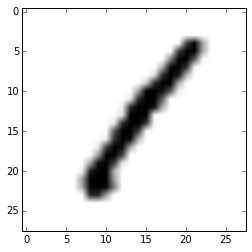

In [176]:
pl.imshow(train.iloc[0,1:].values.reshape(28,28),cmap=pl.cm.gray_r)
print(train.iloc[0,0])

这就是Label为1的图像，train里就包含了42000个这样的样本，那么下面我们利用SVM算法对其进行处理

### 第二步利用SVM进行分类

如果大家对SVM有所了解的话，知道SVM是一种对小样本都具有很好的性能的分类器，而缺点就是运算速度太慢。连sklearn的帮助文档都说，在数据量大于10000时运算速度会很慢，而这里像素点为784个，即有784维的数据，是否会导致算法太慢呢？下面感受一下：

建立一个svm分类器，默认高斯核，gamma越小代表拟合能力越强，C越小代表对outlier点容忍度越低

In [4]:
clf = svm.SVC(gamma=0.001, C=100.)

先利用100个样本进行训练，时间0.03秒很快嘛。

In [52]:
start = time.time()
clf.fit(train.iloc[0:100,1:].values,train.iloc[0:100,0].values)
end = time.time()
print(end-start)

0.0380001068115


2000个样本进行训练，时间6.37秒还凑合。

In [8]:
start = time.time()
clf.fit(train.iloc[0:2000,1:].values,train.iloc[0:2000,0].values)
end = time.time()
print(end-start)

6.3710000515


3000个样本点，时间15.5秒，这时间增长不是线性的啊！

In [9]:
start = time.time()
clf.fit(train.iloc[0:3000,1:].values,train.iloc[0:3000,0].values)
end = time.time()
print(end-start)

15.486000061


4000个样本点，时间28.4秒！可以预见，42000个样本点时，运行时间超出我们的想象

In [5]:
start = time.time()
clf.fit(train.iloc[0:4000,1:].values,train.iloc[0:4000,0].values)
end = time.time()
print(end-start)

28.4400000572


以上对比可以看出，随着数量的增多，SVM运算时间呈几何数量增加，SVM更适合于小样本问题，那么怎么利用好42000个样本呢？在网上baidu一下，发现对于这种多维问题，需要先对数据进行PCA降维，维度下来了，运行时间嗖嗖嗖的就下来了。。。

In [182]:
pca_model = PCA(n_components=35, copy=False, whiten=True)
train_X = pca_model.fit_transform(train.iloc[:,1:].values)
test_X = pca_model.transform(test.values)

我们这里将维度设为35，其实也是试试看的，多点少点都没问题，然后将feature和target分别赋值，也就是下面的X_digits和y_digits

In [183]:
X_digits = train_X
y_digits = train.iloc[:,0].values

In [184]:
print X_digits.shape
print y_digits.shape

(42000L, 35L)
(42000L,)


那么降维后是否运算速度在我们承受范围之内呢？下面我们用上所有样本试一下时间~

In [187]:
start = time.time()
clf.fit(X_digits, y_digits)
end = time.time()
print(end-start)

22.0510001183


22秒，在承受范围之内了！  

SVM的运算速度问题解决了。众所周知SVM还有个需要解决的问题就是调整参数，下面利用cross validation进行调参,注意到即使进行了PCA降维，太多的样本点还是很耗时间，于是只采用1000个样本点进行CROSS validation

In [189]:
xcross = X_digits[:1000,:]
ycross = y_digits[:1000]

In [192]:
Cs=[1,10,100]
gammas = [0,0.01,0.1]
scores = np.zeros([len(Cs),len(gammas)])
for i in range(len(Cs)):
    for j in range(len(gammas)):
        kfold = cross_validation.KFold(len(xcross), n_folds=5)
        clf = svm.SVC(C=Cs[i],gamma=gammas[j], )
        scores[i][j] = np.mean([clf.fit(xcross[train], ycross[train]).score(X_digits[test], ycross[test]) for train, test in kfold])

In [193]:
scores

array([[ 0.896,  0.877,  0.755],
       [ 0.899,  0.881,  0.769],
       [ 0.899,  0.879,  0.769]])

可以通过scores确定最优参数，进行预测，发现C的值对结果影响不大，gamma越小越好，确定最终的模型,并对TEST集预测

In [ ]:
clf = svm.SVC(C=10,gamma=0, )
clf.fit(X_digits, y_digits)
predictResult = clf.predict(test_X)

In [109]:
predictResult

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

### 第三步将结果写入csv中

pandas有个to_csv的函数很好用，针对dataframe的内置函数，首先要将结果整合为拥有index和columns name的dataframe，然后对index name进行设置，注意这里index name只能在df生成后进行修改

In [167]:
dfResult = pd.DataFrame(predictResult,index = [x+1 for x in range(len(test_X))] ,columns = ['Label'])

In [168]:
dfResult.index.name='ImageID'

最后的result长这样：

In [164]:
dfResult

,Lable
ImageID,
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


In [169]:
dfResult.to_csv('result.csv')

然后就是提交啦。最后的结果是正确率达到了98.37%，在835个队伍中排名184，还是很不错的~